In [47]:
# Data Handling
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')
import joblib
import datetime
import os

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
import klib
%matplotlib inline

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Modeling
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
from vecstack import StackingTransformer
from vecstack import stacking
from itertools import combinations
seed = 43

# CV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kfold = KFold(n_splits=4, shuffle=True, random_state=seed)

# Hyperparameter Optimization
from bayes_opt import BayesianOptimization

# Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from scipy.stats.mstats import gmean

<font color='CC3D3D'>

# Ch.4 Modeling


<font color='green'>

## Data 

In [3]:
train = pd.read_csv('./data/train_After_prepro_week4.csv')
test = pd.read_csv('./data/test_After_prepro_week4.csv')
y_target = pd.read_csv('./data/y_target.csv')
y_target_log = np.log1p(y_target)

In [4]:
# data split 
X_train, X_valid, y_train, y_valid = train_test_split(train, y_target_log, test_size=0.2,random_state = seed)

<font color='green'>

## Basic Model
 - 단일 모델 기본 성능 확인

In [5]:
extra_reg = ExtraTreesRegressor(random_state=seed, n_jobs=-1)
xgb_reg = XGBRegressor(random_state=seed, n_jobs=-1)
lgb_reg = LGBMRegressor(random_state=seed, n_jobs=-1)
cat_reg = CatBoostRegressor(random_state=seed, verbose=False)

In [6]:
def get_model_cv_prediction(model, feature_data, y_target):
    neg_mse_scores = cross_val_score(model, feature_data, y_target, scoring='neg_mean_squared_error', cv=4)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print(f'{model.__class__.__name__} 모델의 평균 RMSE: {avg_rmse:.3f}')

In [7]:
models = [extra_reg, xgb_reg, lgb_reg, cat_reg]
for model in models:
    get_model_cv_prediction(model, X_train, y_train)

ExtraTreesRegressor 모델의 평균 RMSE: 2.075
XGBRegressor 모델의 평균 RMSE: 2.037
LGBMRegressor 모델의 평균 RMSE: 1.959
CatBoostRegressor 모델의 평균 RMSE: 1.927


<font color='green'>

## Bayesian Optimization
 - 단일 모델 튜닝 성능 확인

In [8]:
BO_tuned_regs = []

#### ExtraTreesTregressor

In [9]:
pbounds = { 'n_estimators': (100, 500),
            'max_depth': (10,30),    
            'max_features': (0.8, 1.0),
            'min_samples_split': (2, 20), # 노드를 분할하기 위한 최소한의 데이터 수
            'min_samples_leaf': (1, 10)   # 리프노드가 되기 위한 최소한의 샘플 데이터 수
            }

def extra_opt(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):

    params = {
        'n_estimators': int(round(n_estimators)),
        'max_depth': int(round(max_depth)),
        'max_features' : max_features,
        'min_samples_leaf': int(round(min_samples_leaf)),
        'min_samples_split': int(round(min_samples_split)),
        'n_jobs' : -1,
        'random_state' : seed 
    }
    
    extra = ExtraTreesRegressor(**params)

    neg_mse_scores = cross_val_score(extra, X_train, y_train, scoring='neg_mean_squared_error', cv=kfold, n_jobs=-1)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    
    return - (avg_rmse)

BO_extra = BayesianOptimization(f = extra_opt, pbounds = pbounds, random_state=seed) 

In [10]:
BO_extra.maximize(init_points=20, n_iter=20)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        | -2.128    |  12.3     |  0.9218   |  2.201    |  6.331    |  230.9    |
|  2        | -2.083    |  27.18    |  0.9332   |  5.87     |  2.522    |  393.5    |
|  3        | -2.079    |  17.9     |  0.9604   |  3.29     |  3.024    |  446.7    |
|  4        | -2.103    |  14.42    |  0.881    |  3.845    |  3.38     |  437.3    |
|  5        | -2.08     |  26.98    |  0.9943   |  4.468    |  19.18    |  278.3    |
|  6        | -2.105    |  23.39    |  0.8165   |  9.074    |  7.364    |  204.9    |
|  7        | -2.15     |  10.1     |  0.9086   |  5.28     |  13.45    |  491.3    |
|  8        | -2.084    |  28.17    |  0.982    |  5.727    |  3.872    |  172.4    |
|  9        | -2.102    |  29.06    |  0.8824   |  8.785    |  14.1     |  351.5    |
|  10       | -2.088    |  15.51    |  0.9793   |  2.8

In [11]:
# BO_rf.res  # 모든 성능 들어가있음
BO_extra.max

max_params = BO_extra.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['min_samples_leaf'] = int(round(max_params['min_samples_leaf']))
max_params['min_samples_split'] = int(round(max_params['min_samples_split']))
max_params['n_jobs'] = -1
max_params['random_state'] = seed

max_params

{'max_depth': 29,
 'max_features': 0.8744500155409993,
 'min_samples_leaf': 2,
 'min_samples_split': 11,
 'n_estimators': 401,
 'n_jobs': -1,
 'random_state': 43}

In [12]:
extra_reg = ExtraTreesRegressor(**max_params)
rmse_scores = []
for iter_count, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
    
    X_tra, X_val = X_train.values[train_idx], X_train.values[valid_idx]
    y_tra, y_val = y_train.values[train_idx], y_train.values[valid_idx]
    
    extra_reg.fit(X_tra, y_tra)
    
    pred = extra_reg.predict(X_val)
    rmse_score = np.sqrt(mean_squared_error(y_val, pred))
    rmse_scores.append(rmse_score)
print(f'모델의 평균 성능:  {np.mean(rmse_scores):.3f}')
BO_tuned_regs.append((extra_reg.__class__.__name__, extra_reg, np.mean(rmse_scores)))


모델의 평균 성능:  2.067


#### XGBRegressor

In [13]:
pbounds = {'learning_rate': (0.01, 0.1),
            'n_estimators': (90,150),
            'max_depth': (3, 10),   
            'subsample': (0.8, 1),
            'colsample_bytree' : (0.7, 1),
            'min_child_weight': (1,7),
            'gamma': (0, 5) 
            }

def xgb_opt(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, min_child_weight, gamma):
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': int(round(min_child_weight)),
        'gamma': gamma,
        'n_jobs' : -1,
#        'obejective' : 'binary:logistic',
        'random_state' : seed
    }

    xgb_reg = XGBRegressor(**params)
    
    nmse_score = cross_val_score(xgb_reg, X_train, y_train,scoring = 'neg_mean_squared_error', cv=kfold, n_jobs=-1)
    rmse_score = np.sqrt(-nmse_score)
    avg_rmse = np.mean(rmse_score)
    
    return -avg_rmse

BO_xgb = BayesianOptimization(f = xgb_opt, pbounds = pbounds, verbose=2, random_state=seed)

In [14]:
BO_xgb.maximize(init_points=20, n_iter=20)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -2.159    |  0.7345   |  3.045    |  0.02201  |  4.684    |  2.963    |  141.5    |  0.9332   |
|  2        | -1.974    |  0.8623   |  0.1451   |  0.07604  |  5.765    |  5.812    |  105.3    |  0.8114   |
|  3        | -2.003    |  0.96     |  1.105    |  0.04645  |  5.213    |  1.46     |  140.6    |  0.9698   |
|  4        | -1.971    |  0.9914   |  1.927    |  0.0959   |  6.12     |  5.018    |  94.95    |  0.9794   |
|  5        | -3.881    |  0.7894   |  1.312    |  0.01046  |  6.802    |  3.854    |  128.2    |  0.9956   |
|  6        | -2.017    |  0.9726   |  4.551    |  0.05727  |  3.728    |  2.085    |  147.2    |  0.8824   |
|  7        | -1.997    |  0.9595   |  3.361    |  0.06659  |  4.929    |  6.38     |  102.4    |  0.8809   |
|  8      

In [15]:
max_params = BO_xgb.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['min_child_weight'] = int(round(max_params['min_child_weight']))
max_params['n_jobs'] = -1
#max_params['objective'] = 'binary:logistic'
max_params['random_state'] = seed

max_params

{'colsample_bytree': 1.0,
 'gamma': 2.664391252724993,
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 137,
 'subsample': 1.0,
 'n_jobs': -1,
 'random_state': 43}

In [16]:
xgb_reg = XGBRegressor(**max_params)
rmse_scores = []
for iter_count, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
    
    X_tra, X_val = X_train.values[train_idx],X_train.values[valid_idx]
    y_tra, y_val = y_train.values[train_idx], y_train.values[valid_idx]
    
    xgb_reg.fit(X_tra, y_tra)
    
    pred = xgb_reg.predict(X_val)
    rmse_score = np.sqrt(mean_squared_error(y_val, pred))
    rmse_scores.append(rmse_score)
print(f'XGB 모델의 튜닝 평균 성능:  {np.mean(rmse_scores):.3f}')
BO_tuned_regs.append((xgb_reg.__class__.__name__, xgb_reg, np.mean(rmse_scores)))


XGB 모델의 튜닝 평균 성능:  1.958


#### LGBMRegressor

In [17]:
pbounds = {'learning_rate' : (0.01,0.1),
           'n_estimators' : (1000,1300),
           'max_depth' : (15,200),
           'subsample' : (0.8,1),
           'colsample_bytree' : (0.7,1.0),
           'min_child_samples' : (20, 30), 
           'num_leaves': (20, 45)
           }

def lgb_opt(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, min_child_samples, num_leaves):
    
    params = {
        'learning_rate' : learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth': int(round(max_depth)),
        'subsample' : subsample,
        'colsample_bytree' : colsample_bytree,
        'min_child_samples' : int(round(min_child_samples)),
        'num_leaves' : int(round(num_leaves)),
#        'objective' : 'binary',
        'random_state' : seed,
        'n_jobs' : -1
    }

    lgb_reg = LGBMRegressor(**params)
    
    nmse_score = cross_val_score(lgb_reg, X_train, y_train,scoring = 'neg_mean_squared_error', cv=kfold, n_jobs=-1)
    rmse_score = np.sqrt(-nmse_score)
    avg_rmse = np.mean(rmse_score)
    
    return -avg_rmse


BO_lgb = BayesianOptimization(f = lgb_opt, pbounds = pbounds, random_state=seed)

In [18]:
BO_lgb.maximize(init_points=20, n_iter=20)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -1.941    |  0.7345   |  0.06482  |  39.68    |  22.41    |  1.098e+0 |  41.48    |  0.9332   |
|  2        | -1.93     |  0.8623   |  0.01261  |  150.7    |  23.95    |  1.241e+0 |  26.36    |  0.8114   |
|  3        | -1.925    |  0.96     |  0.02989  |  89.92    |  23.16    |  1.023e+0 |  41.08    |  0.9698   |
|  4        | -1.931    |  0.9914   |  0.04468  |  191.6    |  24.46    |  1.201e+0 |  22.06    |  0.9794   |
|  5        | -1.92     |  0.7894   |  0.03361  |  15.95    |  25.43    |  1.143e+0 |  35.91    |  0.9956   |
|  6        | -1.959    |  0.9726   |  0.09191  |  112.2    |  21.04    |  1.054e+0 |  43.83    |  0.8824   |
|  7        | -1.944    |  0.9595   |  0.0705   |  131.3    |  22.76    |  1.269e+0 |  25.17    |  0.8809   |
|  8      

In [19]:
max_params = BO_lgb.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['min_child_samples'] = int(round(max_params['min_child_samples']))
max_params['num_leaves'] = int(round(max_params['num_leaves']))
#max_params['objective'] = 'binary'
max_params['n_jobs'] = -1
max_params['random_state'] = seed

max_params

{'colsample_bytree': 0.7187246604023935,
 'learning_rate': 0.030369810079773983,
 'max_depth': 26,
 'min_child_samples': 29,
 'n_estimators': 1136,
 'num_leaves': 36,
 'subsample': 0.871621684169645,
 'n_jobs': -1,
 'random_state': 43}

In [20]:
lgb_reg = LGBMRegressor(**max_params)
rmse_scores = []
for iter_count, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
    
    X_tra, X_val = X_train.values[train_idx],X_train.values[valid_idx]
    y_tra, y_val = y_train.values[train_idx], y_train.values[valid_idx]
    
    lgb_reg.fit(X_tra, y_tra)
    
    pred = lgb_reg.predict(X_val)
    rmse_score = np.sqrt(mean_squared_error(y_val, pred))
    rmse_scores.append(rmse_score)
print(f'LGBM 모델의 튜닝 평균 성능:  {np.mean(rmse_scores):.3f}')
BO_tuned_regs.append((lgb_reg.__class__.__name__, lgb_reg, np.mean(rmse_scores)))


LGBM 모델의 튜닝 평균 성능:  1.917


#### CatBoostRegressor

In [21]:
cat_reg = CatBoostRegressor(random_state=seed, verbose=False)
rmse_scores = []
for iter_count, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
    
    X_tra, X_val = X_train.values[train_idx],X_train.values[valid_idx]
    y_tra, y_val = y_train.values[train_idx], y_train.values[valid_idx]
    
    cat_reg.fit(X_tra, y_tra)
    
    pred = cat_reg.predict(X_val)
    rmse_score = np.sqrt(mean_squared_error(y_val, pred))
    rmse_scores.append(rmse_score)
print(f'Cat 모델의 튜닝 평균 성능:  {np.mean(rmse_scores):.3f}')
BO_tuned_regs.append((cat_reg.__class__.__name__, cat_reg, np.mean(rmse_scores)))

Cat 모델의 튜닝 평균 성능:  1.927


<font color='green'>

## Ensemble
 1. Averaging
 2. Staking
 3. Seed Ensemble

In [22]:
print(BO_tuned_regs)
regs_tuned = BO_tuned_regs.copy()

[('ExtraTreesRegressor', ExtraTreesRegressor(max_depth=29, max_features=0.8744500155409993,
                    min_samples_leaf=2, min_samples_split=11, n_estimators=401,
                    n_jobs=-1, random_state=43), 2.067386208274592), ('XGBRegressor', XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=2.664391252724993,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=137, n_jobs=-1, num_parallel_tree=1, random_state=43,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method=None, validate_parameters=False, verbosity=None), 1.9576715973684542), ('LGBMRegressor', LGBMRegressor(colsample_bytree=0.7187246604023935,
              learning_rate=0.030369810079773983, max_depth=26,


*Correlation between models*

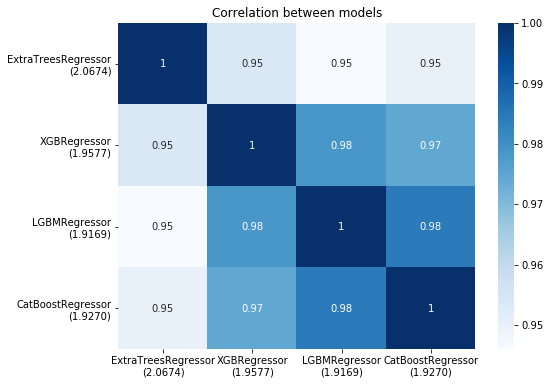

In [23]:
pred_results = []
for name, reg, reg_score in regs_tuned:
    pred = reg.predict(X_valid.values)
    name = f'{name}\n({reg_score:.4f})'
    pred_results.append(pd.Series(pred, name=name))
ensemble_results = pd.concat(pred_results, axis=1)

# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()


    
#### 1. Averaging Ensemble

In [24]:
# Averaging 앙상블에 사용하지 않을 모델은 주석 처리하세요.
selected = [
    'ExtraTreesRegressor',
    'XGBRegressor',
    'LGBMRegressor',
    'CatBoostRegressor'
]
models_for_ensemble = [reg for reg in regs_tuned if reg[0] in selected]

In [25]:
min_score = 99 # 회귀이므로 가장 작은 것이 가장 좋은 것
for p in tqdm([0, 1, 2.56]):  # p==1:산술평균, p=0:기하평균, 그 외:멱평균(주의:멱평균은 과적합 가능성이 높음)   
    for i in range(2, len(models_for_ensemble)+1):
        for models in combinations(models_for_ensemble, i):
            if p == 0:
                pred_mean = gmean([reg.predict(X_valid.values) for name, reg, _ in models], axis=0)
            else:
                preds = [reg.predict(X_valid.values) for name, reg, _ in models]
                pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(models))**(1/p)
            rmse_score = np.sqrt(mean_squared_error(y_valid, pred_mean))
            if min_score > rmse_score:
                best_avg_ensemble = (p, models, rmse_score)
                min_score = rmse_score
                print(f'{min_score}, {"●".join([reg_name for reg_name, _, _ in models])}')

p, models, rmse_score = best_avg_ensemble
print(f'\np={p}\n{"●".join([reg_name for reg_name, _, _ in models])}\n{rmse_score}')

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

2.0835959884000705, ExtraTreesRegressor●XGBRegressor
2.049975060729827, ExtraTreesRegressor●LGBMRegressor
2.02637967951057, XGBRegressor●LGBMRegressor
2.022750014334165, XGBRegressor●CatBoostRegressor
2.003892838651066, LGBMRegressor●CatBoostRegressor


 33%|████████████████████████████                                                        | 1/3 [00:03<00:06,  3.22s/it]

2.0037840310774517, LGBMRegressor●CatBoostRegressor


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:06<00:03,  3.47s/it]

2.003754875575606, LGBMRegressor●CatBoostRegressor


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.43s/it]


p=2.56
LGBMRegressor●CatBoostRegressor
2.003754875575606


   
#### 2. Stacking

In [26]:
# Initialize 1st level estimators
# 사용하지 않을 모델은 주석 처리하세요.
selected = [
    'ExtraTreesRegressor',
    'XGBRegressor',
    'LGBMRegressor',
    'CatBoostRegressor'
]
estimators = [(name, reg) for name, reg, _ in regs_tuned if name in selected]
              
# Initialize StackingTransformer
stack = StackingTransformer(estimators, regression=True, needs_proba=False, metric=None,
                            n_folds=4, stratified=False, shuffle=True, random_state=seed)

# Fit
stack = stack.fit(X_train, y_train)

# Get your stacked features
S_train = stack.transform(X_train)
S_valid = stack.transform(X_valid)
S_test = stack.transform(test) 



In [27]:
# 메타 모델로 보팅을 사용
voting = VotingRegressor(estimators = estimators, n_jobs=-1)
meta_model_voting = voting.fit(S_train, y_train)

stacked_pred = meta_model_voting.predict(S_valid)
rmse_score = np.sqrt(mean_squared_error(y_valid, stacked_pred))
print(f'Meta_Voing 테스트 점수: {rmse_score:.3f}')

Meta_Voing 테스트 점수: 2.012


In [28]:
# Use 2nd level estimator with stacked features
meta_lgb = LGBMRegressor(random_state=seed, n_jobs=-1).fit(S_train, y_train)

meta_pred = meta_lgb.predict(S_valid)
rmse_score = np.sqrt(mean_squared_error(y_valid, meta_pred))
print(f'Meta_Voing 테스트 점수: {rmse_score:.3f}')


Meta_Voing 테스트 점수: 2.017


   
#### 3. Seed_Ensemble

In [41]:
### folder_name 꼭 지정 !!
folder_name = 'models_0720'
model_lst = joblib.load('BO_tuned_2021-07-20.pkl')

In [42]:
### Get Best Score Model
best_model = model_lst[2][1] # load LGBM

if os.path.exists('models') == False:
    os.mkdir('models')
if os.path.exists(f'models/{folder_name}') == False:
    os.mkdir(f'models/{folder_name}')

### Set Random Seed
lucky_seeds = [5616, 3199, 9538]
for iter_count, seed in enumerate(lucky_seeds):
    best_model.random_state = seed
    new_kfold = KFold(n_splits=4, shuffle=True, random_state=seed)
    
    rmse_scores = []
    for iter_count, (train_idx, valid_idx) in enumerate(new_kfold.split(X_train, y_train)):

        X_tra, X_val = X_train.values[train_idx],X_train.values[valid_idx]
        y_tra, y_val = y_train.values[train_idx], y_train.values[valid_idx]

        best_model.fit(X_tra, y_tra)
        joblib.dump(best_model, f'models/{folder_name}/{best_model.__class__.__name__}_{iter_count+1}_{seed}.pkl')
        
        pred = best_model.predict(X_val)
        rmse_score = np.sqrt(mean_squared_error(y_val, pred))
        rmse_scores.append(rmse_score)
        print(f'SEED: {seed}, {iter_count+1}번째 모델 RMSE {rmse_score:.3f}')
    print(f'{best_model.__class__.__name__}_{seed} 모델의 튜닝 평균 성능:  {np.mean(rmse_scores):.3f}')

print(f'모델 {len(lucky_seeds) * kfold.n_splits}개 학습 완료 !')

### load models & predict
model_names = os.listdir(f'models/{folder_name}')
model_lst = [x for x in model_names if x.endswith(".pkl")]
# assert len(models_lst) == 12 # 12개 아니면 error
# 위에꺼는 나중에


### gmean
preds = []
for model_name in model_lst:
    model = joblib.load(f'models/{folder_name}/'+model_name)
    predict_ = model.predict(test)
    preds.append(predict_)
pred_mean = gmean([pred for pred in preds])
pred_mean_expm = np.expm1(pred_mean)
sub = pd.DataFrame({'KR_TRADE_HSCD_COUNTRYCD':pred_mean})
sub.to_csv(f'seed_Ensemble_submission_{folder_name}.csv', index=False)
print('Seed Ensemble submission 출력 완료!')

SEED: 5616, 1번째 모델 RMSE 1.991
SEED: 5616, 2번째 모델 RMSE 1.921
SEED: 5616, 3번째 모델 RMSE 1.964
SEED: 5616, 4번째 모델 RMSE 1.861
LGBMRegressor_5616 모델의 튜닝 평균 성능:  1.934
SEED: 3199, 1번째 모델 RMSE 1.925
SEED: 3199, 2번째 모델 RMSE 1.933
SEED: 3199, 3번째 모델 RMSE 1.933
SEED: 3199, 4번째 모델 RMSE 1.886
LGBMRegressor_3199 모델의 튜닝 평균 성능:  1.919
SEED: 9538, 1번째 모델 RMSE 1.957
SEED: 9538, 2번째 모델 RMSE 1.870
SEED: 9538, 3번째 모델 RMSE 1.931
SEED: 9538, 4번째 모델 RMSE 1.942
LGBMRegressor_9538 모델의 튜닝 평균 성능:  1.925
모델 12개 학습 완료 !
Seed Ensemble submission 출력 완료!


<font color='green'>


###  Submission
 - 앙상블까지 성능을 보았을때 가장 높은 성능인 LGBM으로 최종 서브미션 제출

In [44]:
model_lst = joblib.load('BO_tuned_2021-07-20.pkl')
best_model = model_lst[2][1] # load LGBM

final_pred = best_model.predict(test.values)
final_pred_expm = np.expm1(final_pred)
pd.DataFrame({'KR_TRADE_HSCD_COUNTRYCD': final_pred_expm}).to_csv(f'submission.csv', index=False)

In [45]:
display(pd.read_csv('submission.csv'))

,KR_TRADE_HSCD_COUNTRYCD
0,1.427161e+04
1,1.807954e+06
2,1.989917e+05
3,2.724772e+05
4,1.564751e+05
...,...
21184,2.499173e+06
21185,3.508771e+06
21186,8.278248e+05
21187,1.474260e+07


<font color='green'>

## Save Models

In [31]:
now = datetime.datetime.now()
nowDate = now.strftime('%Y-%m-%d')
print(nowDate)

2021-07-20


In [34]:
joblib.dump(BO_tuned_regs,f'BO_tuned_{nowDate}.pkl')

['BO_tuned_2021-07-20.pkl']

# ────────────────── End of Pipeline3/3 ──────────────────